# Préparation du dataset

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [8]:
data = pd.read_csv('data/images.csv')
data['image_path'] = data['image_path'].apply(lambda x: f'./data/Flipkart/Images/{x}')
data.head()

,image_path,label_name,label
0,./data/Flipkart/Images/009099b1f6e1e8f893ec29a...,Watches,6
1,./data/Flipkart/Images/0096e89cc25a8b96fb98087...,Kitchen & Dining,5
2,./data/Flipkart/Images/00cbbc837d340fa163d11e1...,Home Furnishing,4
3,./data/Flipkart/Images/00d84a518e0550612fcfcba...,Beauty and Personal Care,1
4,./data/Flipkart/Images/00e966a5049a262cfc72e6b...,Computers,2


In [9]:
from sklearn import preprocessing

path = "./data/Flipkart/Images/"


list_labels = ["Home Furnishing", "Baby Care", "Watches", "Kitchen & Dining", "Beauty and Personal Care", "Computers", "Home Decor & Festive Needs"]
label_no_name = "no_name"



In [10]:
data.groupby("label").count()

,image_path,label_name
label,,
0,39,39
1,37,37
2,26,26
3,43,43
4,51,51
5,43,43
6,38,38


Home Furnishing
./data/Flipkart/Images/00cbbc837d340fa163d11e169fbdb952.jpg
./data/Flipkart/Images/037c2402fee39fbc80433935711d1383.jpg
./data/Flipkart/Images/04f9ff160a1561e3656350f4bd6b8c50.jpg


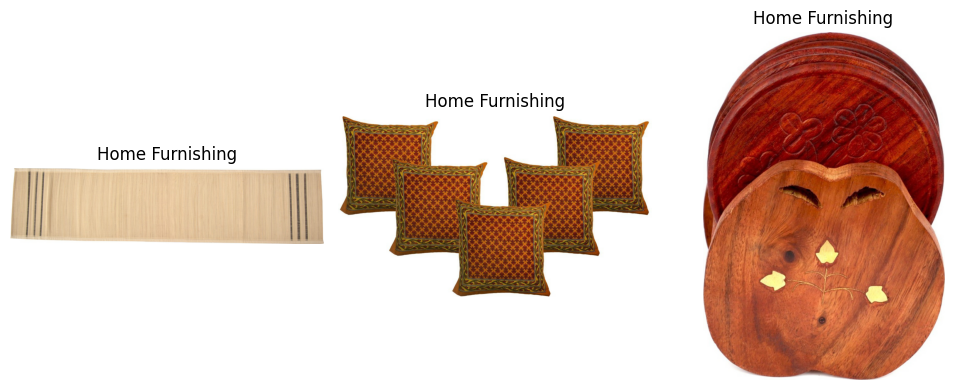

Baby Care
./data/Flipkart/Images/057836ecde71565f8ebdd576e41fdc96.jpg
./data/Flipkart/Images/0906fd9cc604fbba05a502e01d763cd9.jpg
./data/Flipkart/Images/093bcad64d11c0aed903a8dd787ef069.jpg


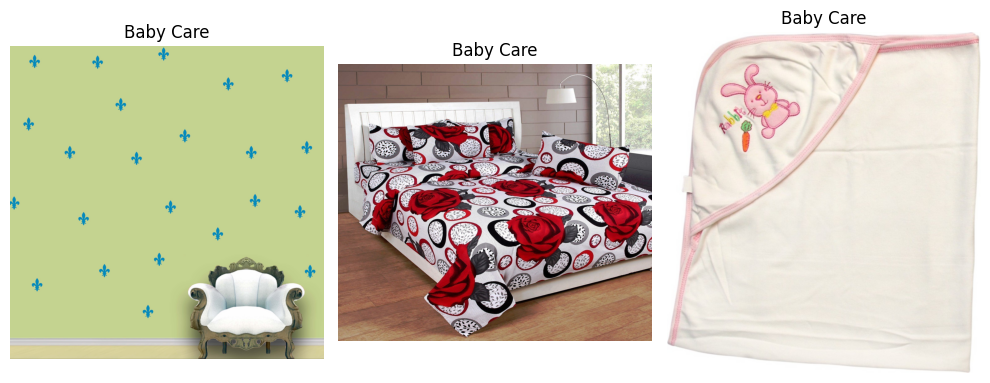

Watches
./data/Flipkart/Images/009099b1f6e1e8f893ec29a7023153c4.jpg
./data/Flipkart/Images/052559ede419996737893eb47568ee7f.jpg
./data/Flipkart/Images/059bc43e03e1824a9ab6466e32e5f137.jpg


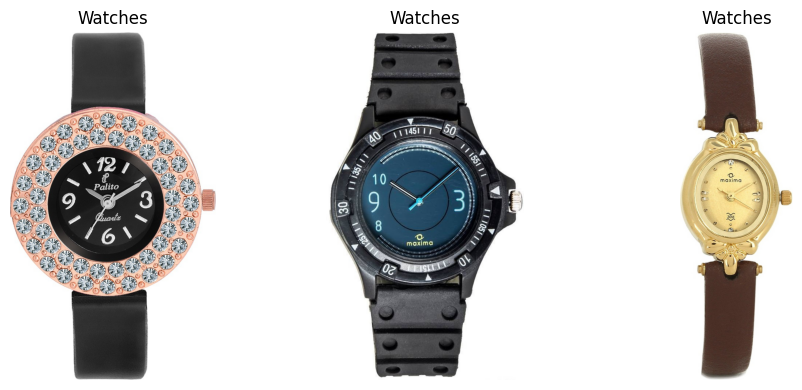

Kitchen & Dining
./data/Flipkart/Images/0096e89cc25a8b96fb9808716406fe94.jpg
./data/Flipkart/Images/0131e5d87b72877702d536299cf83b75.jpg
./data/Flipkart/Images/02127f52e96fb72c66bf081d25104ef8.jpg


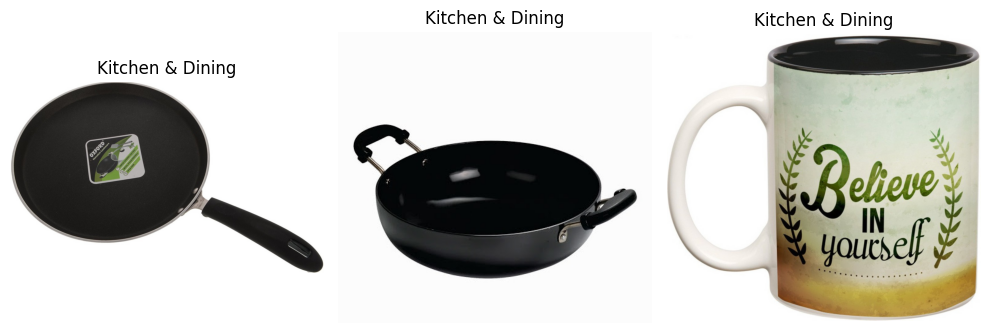

Beauty and Personal Care
./data/Flipkart/Images/00d84a518e0550612fcfcba3b02b6255.jpg
./data/Flipkart/Images/020d2daba55a723128e4e07c0b0393a9.jpg
./data/Flipkart/Images/02a53d335775b652f22f41b529b9d646.jpg


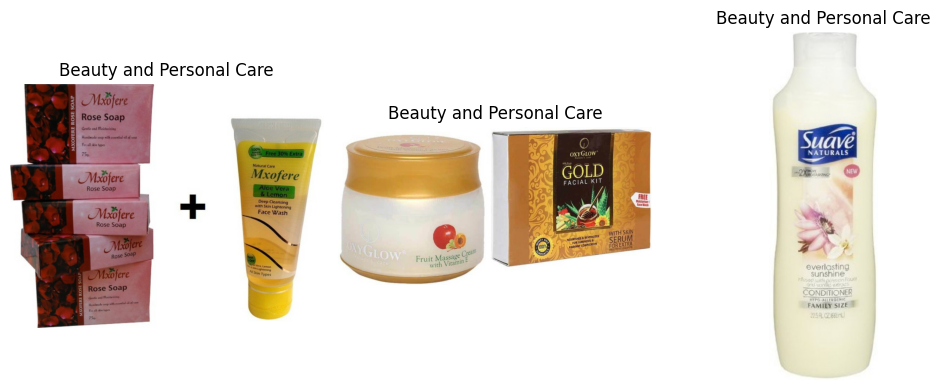

Computers
./data/Flipkart/Images/00e966a5049a262cfc72e6bbf68b80e7.jpg
./data/Flipkart/Images/00ed03657cedbe4663eff2d7fa702a33.jpg
./data/Flipkart/Images/01089dc3618a0ab7304d784ef400b83d.jpg


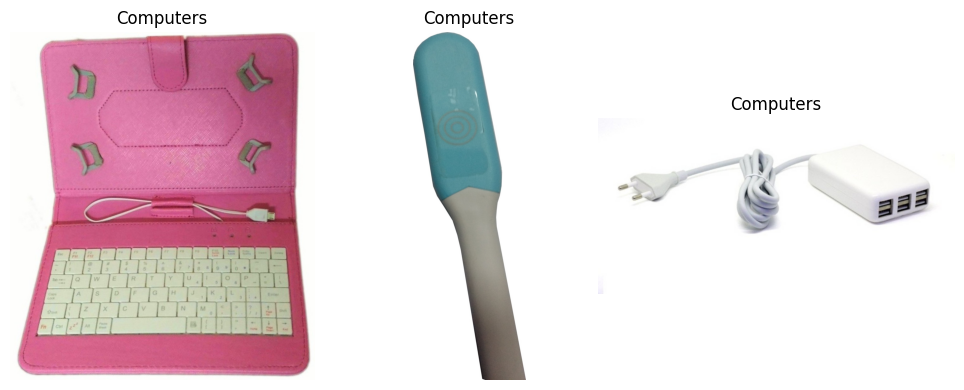

Home Decor & Festive Needs
./data/Flipkart/Images/032e812adcd11a38fd8b764891a852ff.jpg
./data/Flipkart/Images/037b39bef3db7ccd264c577a0edf0c0a.jpg
./data/Flipkart/Images/04f9f818e2d657b873b07578cfe2eade.jpg


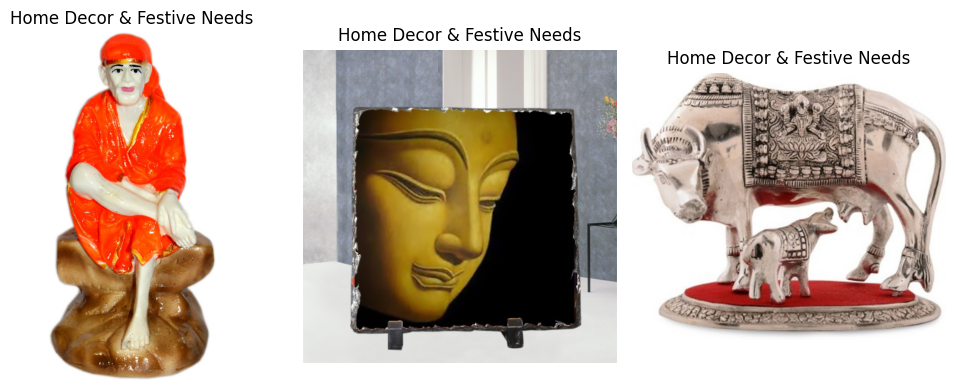

In [11]:
from matplotlib.image import imread
def list_fct(name, data):
    """
    Retourne les chemins d'image associés à une catégorie donnée.
    """
    list_image_name = data[data["label_name"] == name]["image_path"].tolist()
    return list_image_name


for name in list_labels:
    print(name)
    image_paths = list_fct(name, data)
    
   
    if len(image_paths) == 0:
        print(f"Aucune image trouvée pour la catégorie {name}")
        continue
    
   
    plt.figure(figsize=(10, 4))
    for i in range(min(3, len(image_paths))): 
        filename = image_paths[i]
        print(filename)  
        
        try:
            image = imread(filename)  
            plt.subplot(1, 3, i + 1)  
            plt.imshow(image)
            plt.axis("off")
            plt.title(name)
        except FileNotFoundError:
            print(f"Fichier introuvable : {filename}")
    plt.tight_layout()
    plt.show()
    

In [12]:
from sklearn.model_selection import train_test_split

# Séparer les données en 60% pour l'entraînement et 40% pour le test
data, data_test = train_test_split(data, test_size=0.4, stratify=data['label_name'], random_state=42)

# Vérification des tailles des datasets
print(f"Nombre total d'éléments dans le dataset : {len(data)}")
print(f"Nombre total d'éléments dans le dataset de test : {len(data_test)}")

# Vérification de la répartition des labels
print("Répartition des labels dans data :")
print(data['label_name'].value_counts(normalize=True))
print("Répartition des labels dans data_test :")
print(data_test['label_name'].value_counts(normalize=True))


Nombre total d'éléments dans le dataset : 166
Nombre total d'éléments dans le dataset de test : 111
Répartition des labels dans data :
label_name
Home Furnishing               0.180723
Home Decor & Festive Needs    0.156627
Kitchen & Dining              0.156627
Watches                       0.138554
Baby Care                     0.138554
Beauty and Personal Care      0.132530
Computers                     0.096386
Name: proportion, dtype: float64
Répartition des labels dans data_test :
label_name
Home Furnishing               0.189189
Home Decor & Festive Needs    0.153153
Kitchen & Dining              0.153153
Baby Care                     0.144144
Watches                       0.135135
Beauty and Personal Care      0.135135
Computers                     0.090090
Name: proportion, dtype: float64


# Etape 1 : étude de faisabilité

## Création du modèle pré-entraîné

In [13]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


## Création des features des images

In [14]:
images_features = []
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0


c:\Users\misss\Formation\Projets\Classification\ClassifiezAutomatiquement\.venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


100


(166, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA

In [15]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(166, 4096)
(166, 151)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [16]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

c:\Users\misss\Formation\Projets\Classification\ClassifiezAutomatiquement\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


temps de T-SNE :             0.52 secondes


C:\Users\misss\AppData\Local\Temp\ipykernel_30592\1577766683.py:5: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


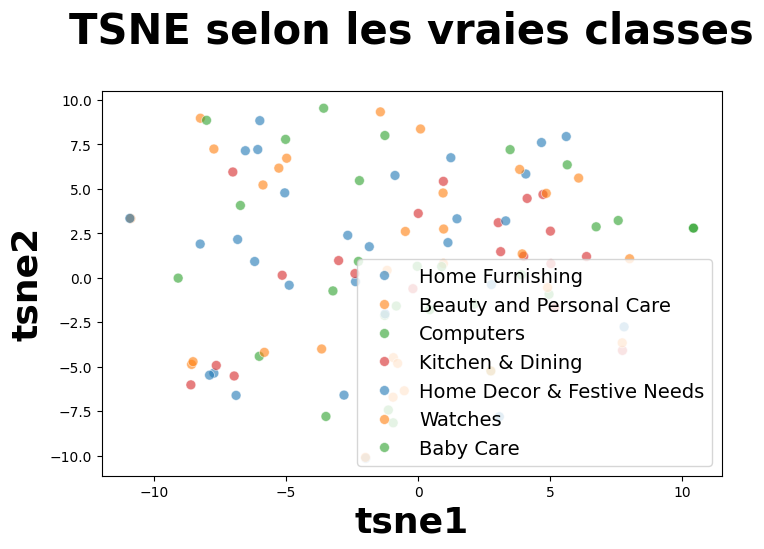

In [17]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes
* Ceci suffit à démontrer la faisabilité de réaliser ultérieurement une classification supervisée pour déterminer automatiquement les classes des images
* Cette étape 1 est très rapide à mettre en oeuvre. Une conclusion négative sur la faisabilité aurait éviter de réaliser des traitements beaucoup plus lourd de classification supervisée
* Cette démarche en 2 étapes (1. Faisabilité, 2. Classification supervisée si étape 1 OK) s'inscrit dans une démarche agile de tout projet Data

### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement


In [18]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=4, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=4, n_init=100)

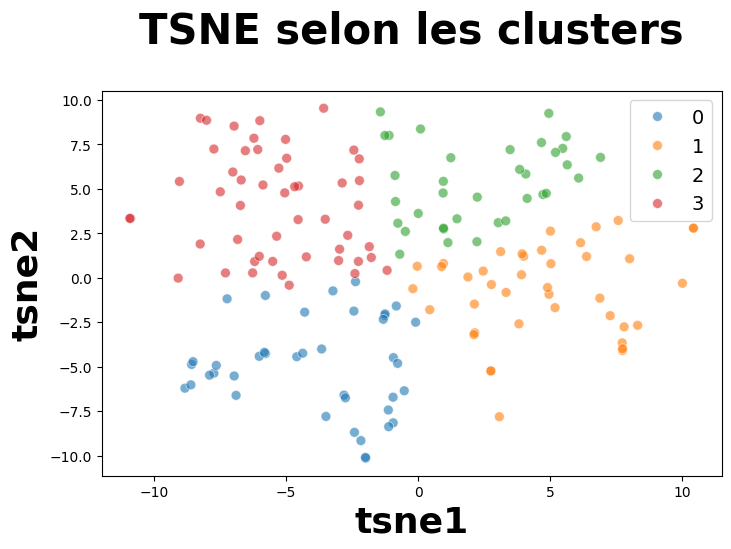

ARI :  0.20766173377549968


In [19]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes

In [21]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[ 0 12 10  1  0  0  0]
 [14  3  3  2  0  0  0]
 [ 7  4  0  5  0  0  0]
 [ 1  7  6 12  0  0  0]
 [ 0 14 16  0  0  0  0]
 [17  0  0  9  0  0  0]
 [ 1  1  0 21  0  0  0]]


In [22]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [23]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [5 4 4 6 0 0 0]
[[ 0  0  0  0 22  0  1]
 [ 0  0  0  0  6 14  2]
 [ 0  0  0  0  4  7  5]
 [ 0  0  0  0 13  1 12]
 [ 0  0  0  0 30  0  0]
 [ 0  0  0  0  0 17  9]
 [ 0  0  0  0  1  1 21]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        16
           3       0.00      0.00      0.00        26
           4       0.39      1.00      0.57        30
           5       0.42      0.65      0.52        26
           6       0.42      0.91      0.58        23

    accuracy                           0.41       166
   macro avg       0.18      0.37      0.24       166
weighted avg       0.20      0.41      0.26       166



c:\Users\misss\Formation\Projets\Classification\ClassifiezAutomatiquement\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\misss\Formation\Projets\Classification\ClassifiezAutomatiquement\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\misss\Formation\Projets\Classification\ClassifiezAutomatiquement\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use 

<Axes: >

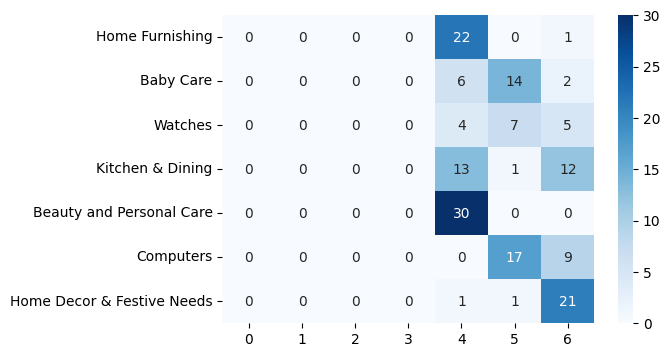

In [29]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

* La classe la moins bien prédite est "shine" (CF exemple ci-dessus : confond la neige avec un nuage)

# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [92]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

## Approche préparation initiale des images

In [ ]:
def image_prep_fct(data):
    prepared_images = []

    data = data.reset_index(drop=True)
    
    for image_num in range(len(data['image_path'])):
        try:

            img = load_img(data['image_path'][image_num], target_size=(224, 224))
            img = img_to_array(img)
            img = preprocess_input(img)
            prepared_images.append(img)
        except Exception as e:
            print(f"Erreur avec l'image {data['image_path'][image_num]} : {e}")

    
    prepared_images_np = np.vstack(prepared_images)
    return prepared_images_np


images_np = image_prep_fct(data)
print("Shape des images pour entraînement :", images_np.shape)

images_np_test = image_prep_fct(data_test)
print("Shape des images pour test :", images_np_test.shape)

Shape des images pour entraînement : (166, 224, 224, 3)


c:\Users\misss\Formation\Projets\Classification\ClassifiezAutomatiquement\.venv\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Shape des images pour test : (111, 224, 224, 3)


In [32]:
X = images_np
y = to_categorical(data['label'])

X_test = images_np_test
y_test = to_categorical(data_test['label'])

y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.45, random_state=42)
X_train.shape

(91, 224, 224, 3)

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
# Création du modèle
with tf.device('/gpu:0'): 
    model1 = create_model_fct()


# Création du callback
model1_save_path1 = "./model1_best_weights.keras"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [47]:
# Compiler le modèle
model1.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Entraîner le modèle
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train,
                          epochs=50,
                          batch_size=64,
                          validation_data=(X_val, y_val),
                          callbacks=callbacks_list,
                          verbose=1)



Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1872 - loss: 10.8507
Epoch 1: val_loss improved from inf to 4.28299, saving model to ./model1_best_weights.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.1870 - loss: 10.7376 - val_accuracy: 0.2667 - val_loss: 4.2830
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2279 - loss: 7.5580
Epoch 2: val_loss improved from 4.28299 to 3.65828, saving model to ./model1_best_weights.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step - accuracy: 0.2362 - loss: 7.4620 - val_accuracy: 0.4533 - val_loss: 3.6583
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4009 - loss: 5.2279
Epoch 3: val_loss improved from 3.65828 to 3.15006, saving model to ./model1_best_weights.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 5s/step - accuracy: 0.3992 - loss: 5.2486 - val_accuracy: 0.5600 - val_loss: 3.1501
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6147 - loss: 3.0467
Epoch 4: val_loss improved from 3.15006 to 2.40289, sa

In [48]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 0.0074
Training Accuracy: 1.0000

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6454 - loss: 1.9817
Validation Accuracy:  0.6267


In [49]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.5867
Test Accuracy       :  0.7027


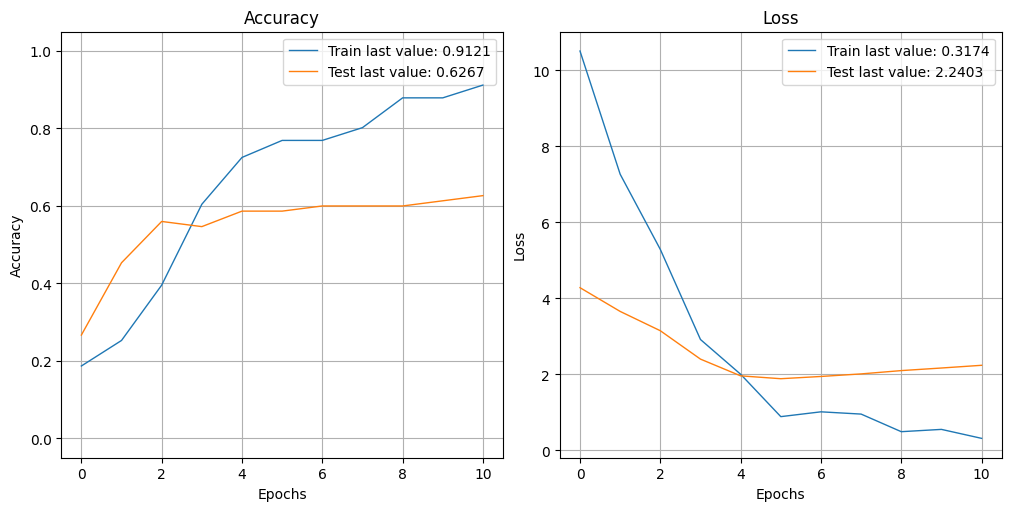

In [51]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [52]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
[4 5 5 4 6 0 4 3 3 6 2 3 1 4 3 4 5 0 6 4 1 0 4 0 5 1 6 2 1 1 2 5 5 0 6 1 2
 1 3 0 3 5 4 3 3 4 4 1 3 3 4 6 2 5 2 0 4 1 2 4 5 6 0 0 5 6 4 3 0 5 3 6 6 1
 5]

[4 5 5 4 6 0 4 3 4 5 5 5 1 0 3 0 5 3 6 4 1 0 0 0 5 1 6 3 1 2 5 1 5 5 6 4 2
 6 4 4 5 5 4 3 6 1 4 6 5 2 4 1 2 5 2 0 4 1 4 5 5 6 4 0 1 6 3 3 4 5 1 6 6 1
 5]


In [53]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[ 5  0  0  1  3  1  0]
 [ 0  6  1  0  1  0  2]
 [ 0  0  3  1  1  2  0]
 [ 0  1  1  4  2  3  1]
 [ 3  1  0  1  8  1  0]
 [ 0  2  0  0  0 10  0]
 [ 0  1  0  0  0  1  8]]


In [54]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[ 5  0  0  1  3  1  0]
 [ 0  6  1  0  1  0  2]
 [ 0  0  3  1  1  2  0]
 [ 0  1  1  4  2  3  1]
 [ 3  1  0  1  8  1  0]
 [ 0  2  0  0  0 10  0]
 [ 0  1  0  0  0  1  8]]

              precision    recall  f1-score   support

           0       0.62      0.50      0.56        10
           1       0.55      0.60      0.57        10
           2       0.60      0.43      0.50         7
           3       0.57      0.33      0.42        12
           4       0.53      0.57      0.55        14
           5       0.56      0.83      0.67        12
           6       0.73      0.80      0.76        10

    accuracy                           0.59        75
   macro avg       0.59      0.58      0.58        75
weighted avg       0.59      0.59      0.58        75



<Axes: >

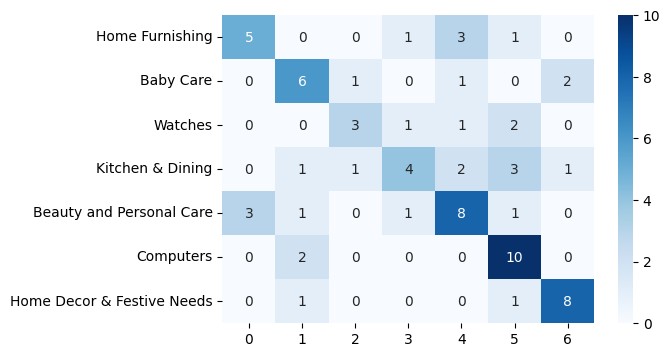

In [56]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [58]:
# Pour mélanger les images, classées initalement par classe
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [69]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(224, 224),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [70]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 125 validated image filenames belonging to 7 classes.
Found 41 validated image filenames belonging to 7 classes.


Found 111 validated image filenames belonging to 7 classes.


In [ ]:
# Création du modèle
with tf.device('/gpu:0'): 
    model2 = create_model_fct()


# Création du callback
model2_save_path = "./model2_best_weights.keras"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,044 (56.64 MB)

 Trainable params: 132,356 (517.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [72]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [73]:
# Compiler le modèle
model2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Entraîner le modèle
with tf.device('/gpu:0'):
    history2 = model2.fit(train_flow,validation_data=val_flow,batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


c:\Users\misss\Formation\Projets\Classification\ClassifiezAutomatiquement\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1226 - loss: 10.2161
Epoch 1: val_loss improved from inf to 5.28777, saving model to ./model2_best_weights.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.1317 - loss: 9.9839 - val_accuracy: 0.3415 - val_loss: 5.2878
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3691 - loss: 5.1595
Epoch 2: val_loss improved from 5.28777 to 3.73217, saving model to ./model2_best_weights.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.3785 - loss: 4.9905 - val_accuracy: 0.3902 - val_loss: 3.7322
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4878 - loss: 3.5147
Epoch 3: val_loss improved from 3.73217 to 1.75467, saving model to ./model2_best_weights.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - accuracy: 0.4894 - loss: 3.5495 - val_accuracy: 0.7073 - val_loss: 1.7547
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6108 - loss: 2.2063
Epoch 4: val_loss did not improve from 1.75467
4/4 ━━━

In [74]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.9830 - loss: 0.0602
Training Accuracy   : 0.9680

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 429ms/step - accuracy: 0.6845 - loss: 2.3447
Validation Accuracy :  0.6829


In [75]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.5854


c:\Users\misss\Formation\Projets\Classification\ClassifiezAutomatiquement\.venv\Lib\site-packages\PIL\Image.py:3406: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Test Accuracy       :  0.6937


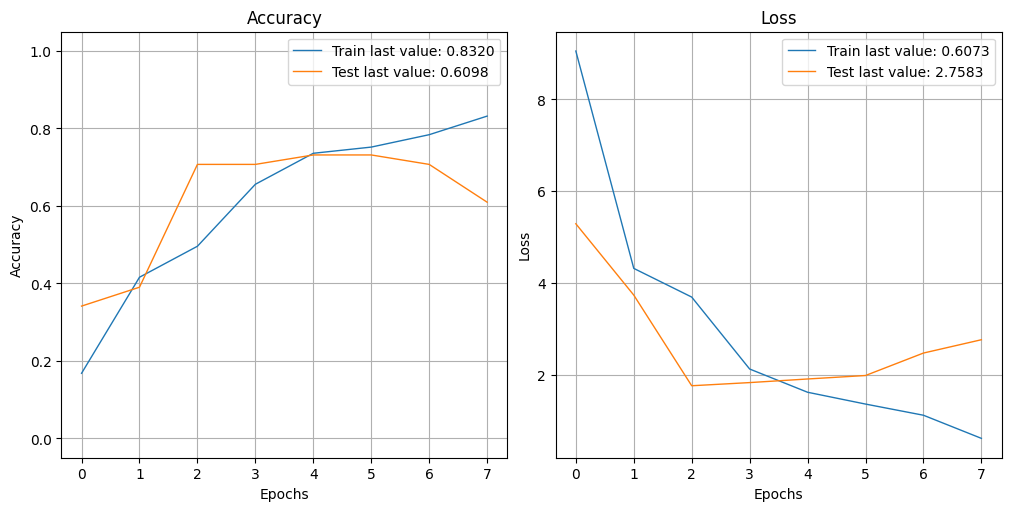

In [76]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [86]:
data.label.tolist()

[6,
 1,
 6,
 0,
 3,
 6,
 6,
 0,
 3,
 6,
 1,
 3,
 5,
 0,
 4,
 1,
 5,
 6,
 4,
 5,
 0,
 3,
 3,
 1,
 1,
 1,
 4,
 0,
 0,
 0,
 0,
 6,
 0,
 4,
 4,
 5,
 1,
 5,
 3,
 0,
 3,
 4,
 5,
 4,
 1,
 5,
 0,
 0,
 5,
 1,
 2,
 3,
 5,
 4,
 4,
 0,
 3,
 5,
 5,
 3,
 6,
 2,
 4,
 6,
 0,
 6,
 4,
 5,
 5,
 3,
 2,
 3,
 0,
 2,
 6,
 3,
 5,
 4,
 4,
 6,
 0,
 5,
 3,
 0,
 4,
 6,
 6,
 5,
 4,
 5,
 4,
 4,
 0,
 1,
 4,
 1,
 2,
 2,
 1,
 6,
 3,
 1,
 3,
 6,
 0,
 1,
 5,
 3,
 5,
 5,
 4,
 3,
 5,
 3,
 4,
 2,
 1,
 2,
 0,
 2,
 1,
 2,
 6,
 2,
 4,
 4,
 5,
 5,
 6,
 2,
 1,
 6,
 0,
 4,
 1,
 5,
 4,
 1,
 4,
 4,
 4,
 2,
 3,
 0,
 4,
 1,
 4,
 6,
 3,
 0,
 3,
 6,
 3,
 5,
 2,
 2,
 4,
 5,
 6,
 6,
 3,
 1,
 1,
 3,
 3,
 2]

In [89]:
batch_size = 32
data_full = pd.read_csv('data/images.csv')
def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels=data_full.label.tolist(), label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [90]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
#images.csv = dataset_fct(path_test, validation_split=0, data_type=None)

Found 277 files belonging to 7 classes.
Using 208 files for training.
Found 277 files belonging to 7 classes.
Using 69 files for validation.


In [94]:
# Création du modèle
with tf.device('/gpu:0'): 
    model3 = create_model_fct()


# Création du callback
model3_save_path = "./model3_best_weights.keras"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_14     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [95]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [96]:
with tf.device('/gpu:0'): 
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2479 - loss: 12.5626
Epoch 1: val_loss improved from inf to 3.44679, saving model to ./model3_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.2596 - loss: 12.2793 - val_accuracy: 0.4348 - val_loss: 3.4468
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5307 - loss: 4.4579
Epoch 2: val_loss improved from 3.44679 to 2.02895, saving model to ./model3_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.5293 - loss: 4.5112 - val_accuracy: 0.6957 - val_loss: 2.0290
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6600 - loss: 2.4241
Epoch 3: val_loss improved from 2.02895 to 1.64624, saving model to ./model3_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6562 - loss: 2.4366 - val_accuracy: 0.7246 - val_loss: 1.6462
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7391 - loss: 1.3626
Epoch 4: val_loss did not improve from 1.64624
7/7 

In [97]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 1.0000 - loss: 9.1199e-04
Training Accuracy   : 1.0000

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7663 - loss: 1.5853
Validation Accuracy :  0.7826


In [98]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

#loss, accuracy = model3.evaluate(images.csv, verbose=False)
#print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7826


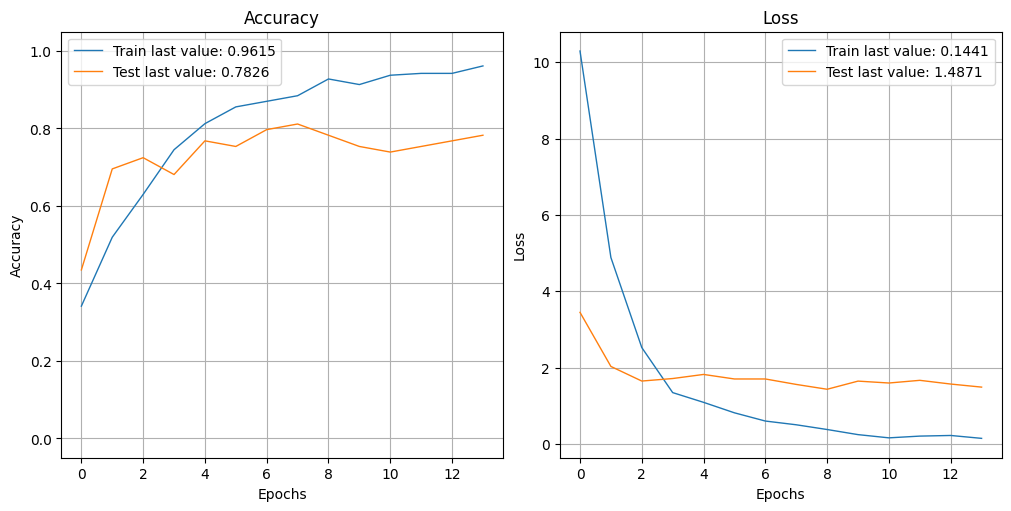

In [99]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [103]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels=data_full.label.tolist(), label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [104]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
#images.csv = dataset_fct(path_test, validation_split=0, data_type=None)

Found 277 files belonging to 7 classes.
Using 208 files for training.
Found 277 files belonging to 7 classes.
Using 69 files for validation.


In [105]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label



In [108]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])
    
    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle 
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())
    
    return model
    

In [111]:
# Création du modèle
with tf.device('/gpu:0'): 
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.keras"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_6 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_18     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,847,815 (56.64 MB)

 Trainable params: 133,127 (520.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [112]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [113]:
with tf.device('/gpu:0'): 
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1724 - loss: 2.1731
Epoch 1: val_loss improved from inf to 1.77299, saving model to ./model4_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.1731 - loss: 2.1662 - val_accuracy: 0.2754 - val_loss: 1.7730
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3249 - loss: 1.7107
Epoch 2: val_loss improved from 1.77299 to 1.66519, saving model to ./model4_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.3209 - loss: 1.7152 - val_accuracy: 0.4058 - val_loss: 1.6652
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4454 - loss: 1.5664
Epoch 3: val_loss improved from 1.66519 to 1.48459, saving model to ./model4_best_weights.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.4462 - loss: 1.5657 - val_accuracy: 0.6087 - val_loss: 1.4846
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5066 - loss: 1.4031
Epoch 4: val_loss improved from 1.48459 to 1.37140, s

In [114]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.9385 - loss: 0.2603
Training Accuracy   : 0.9471

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7144 - loss: 0.8688
Validation Accuracy :  0.7101


In [115]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

#loss, accuracy = model4.evaluate(images.csv, verbose=False)
#print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7536


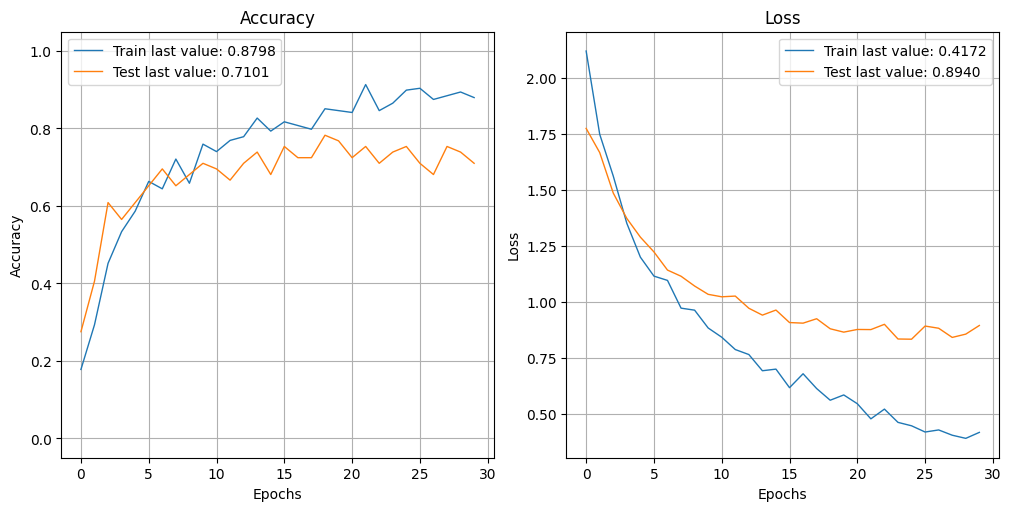

In [116]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()